In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm



# Get Data
We're using data from the [Stress in America survey](https://www.icpsr.umich.edu/web/ICPSR/studies/37288), specifically the 2016 Coping with Change, Part 2: Technology and Social Media wave. You will need an account at ICPSR to download the data to follow along.

In [2]:
# read in the delimited file
df = pd.read_csv('~/Downloads/ICPSR_37288/DS0012/37288-0012-Data.tsv', sep='\t')
print(len(df.columns))

4051


/var/folders/9m/j7pgz2y13pjb5pkntyb1z1sh0000gp/T/ipykernel_62250/3235179643.py:2: DtypeWarning: Columns (163) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('~/Downloads/ICPSR_37288/DS0012/37288-0012-Data.tsv', sep='\t')


The error tells us something is up with column 163. Let's investigate and see if we can fix the problem. Or whether it's even a problem we need to fix.

In [3]:
# Get the name of the column at index 163
column_name = df.columns[163]

# Apply value_counts() to the column
frequencies = df[column_name].value_counts(dropna=False)

# Print the result
print(frequencies)


NETRACEUS
4    461
1    123
2    110
2     91
1     87
3     67
4     40
3     33
       7
Name: count, dtype: int64


We can go to the codebook to figure out what this question is about and what those answers mean. Then we'll figure out why we see values that look the same but that `pandas` is reading as different (e.g., 4 and 4).

The NETRACEUS variable looks like it collapses the many race categories offered earlier in the survey into just 4 groups. This is a categorical variable, so we can use the categories themselves as values instead fo the number to make it more readable.

First, let's make all the values strings since it looks like there's inconsistency in the data type for the column.

In [4]:
df[column_name] = df[column_name].astype(str)

# Now, apply value_counts()
frequencies = df[column_name].value_counts(dropna=False)
print(frequencies)

NETRACEUS
4    501
1    210
2    201
3    100
       7
Name: count, dtype: int64


That gets us the 4 categories we were expecting (plus some missing data). Let's recode those to match the categories.

In [5]:
# Create a dictionary to map the old values to the new values
recoding_dict = {
    '1': 'Hispanic',
    '2': 'Black (not Hispanic)',
    '3': 'Asian (not Hispanic)',
    '4': 'All other (not Hispanic)'
}

# Apply the recoding
df[column_name] = df[column_name].replace(recoding_dict)

# Print the value counts again to verify the changes
print(df[column_name].value_counts(dropna=False))

NETRACEUS
All other (not Hispanic)    501
Hispanic                    210
Black (not Hispanic)        201
Asian (not Hispanic)        100
                              7
Name: count, dtype: int64


There may be other issues with the data that we discover as we go, but at least we have the read error fixed.

# Explore Data

Before we get much further, let's take a look at some of the variables we might use in this data. The textbook has questions on p. 74 that are a good starting point. We're not going to use all 4051 variables. Let's first choose some to keep.

I noticed while prepping this demo that many of the variables in the dataset have *only* missing values. Let's start by getting rid of those.

In [6]:
# Create a boolean series where True means the column is entirely empty
is_empty = ((df.replace(r'^\s*$', np.nan, regex=True)
             .isnull()
             .all()
             ))

# Get the names of the columns that are all empty
empty_columns = list(is_empty[is_empty].index)

print("N of columns that are all empty or full of whitespace:")
print(len(empty_columns))

/var/folders/9m/j7pgz2y13pjb5pkntyb1z1sh0000gp/T/ipykernel_62250/1989302607.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  is_empty = ((df.replace(r'^\s*$', np.nan, regex=True)


N of columns that are all empty or full of whitespace:
3805


In [7]:
df_usable = df.drop(columns=empty_columns)
print(len(df_usable))

1019


We're left with only 1019 columns. That seems odd, so I messaged the ICPSR team to figure out what's up with this dataset. Luckily we're just reviewing stats and not actually using the data to make decisions, so we'll press on.

Let's see which of those remaining variables might be interesting to work with. We have too many variables for Jupyter to display, so we have to use a loop to print them out.

In [8]:
for column in df_usable.columns:
    print(column)

UNIQUE
RECORD
YEAR
Q75
Q260
Q3000
Q6030
Q271
Q268R1
Q268R2
Q268R3
Q268R5
Q268B
DMAGE
Q270
NETAGE
NETGENAGE
DMZIPUS
DMMARSTAT
NETMARSTAT
DMADULTHH
DMCHILDHH
Q1372
NETHHSIZE
Q3004
Q3015R1C1
Q3015R2C1
Q3015R3C1
Q3015R4C1
Q3015R5C1
Q3015R6C1
Q3015XR1
Q3015XR2
Q3015XR3
Q3015XR4
Q3015XR5
Q3015XR6
Q4000R1
Q4000R2
Q4000R3
Q4000R4
Q4000R5
Q4000R6
Q4000R7
Q4000R8
Q4000R9
Q4000R10
Q4000R11
Q4000R12
Q4000R13
Q4000R14
Q4000R15
Q4000R16
Q4000R17
Q4000R18
Q4000R19
Q4000R20
Q4000R21
Q4000R22
Q4000R23
Q4000R24
Q4000R25
Q4000R26
Q4000R27
Q4000R28
Q4000R29
Q4000R30
Q4000R31
Q4000R32
Q4000R33
Q4000R34
Q4000R35
Q4000R36
Q4005
Q396
Q398_1
Q398_2
Q398_3
Q398_4
Q402
Q404M1
Q404M2
Q404M3
Q404M97
Q406_1
Q406_2
Q406_3
Q406_4
Q406_5
Q406_6
Q406_7
Q406_8
Q406_9
Q406_15
Q406_99
DMEMPLOY
NETEMPLOY
Q474
Q484M1
Q484M2
Q484M8
Q484M3
Q484M4
Q484M6
Q484M7
Q484M9
Q484M10
Q484M12
Q484M13
Q484M14
Q484M15
Q484M16
Q484M17
Q484M18
Q484M94
Q484M5
Q484M99
FINRACEUS
NETRACEUS
Q700
Q3020
Q605
Q625R1
Q625R2
Q625R3
Q625R4
Q625R5
Q62

Some interesting variables:
- Q625: For each one, please indicate how significant a source of stress it is in your life (1-4, Not at all significant - Very significant)
- Q810: Which of the following, if any, have you experienced in the last month as a result of
stress? (List of things, e.g., headache)
- Q3051: How would you rate your neighborhood on the following? (1-4, A big problem - Not a problem)
- Q350:

Many of the other variables are demographic (e.g., Male: how do you describe yourself?). For purposes of class, I'm going to exclude those. One really common step in data analysis is to segment data according to demographic variables. Doing so helps us identify disparities, for instance. But today we're focusing on reviewing steps to analyzing data, so we're going to avoid the pitfalls of reductionist views on demographics. We're going to keep just one so that I can demo looking for covariates though: NETAGE.

In [9]:
# Create a list of the column names you want to keep
demog_columns_to_keep = ['NETAGE']

# Add columns from Q9015:
outcome_columns_to_keep = [col for col in df.columns if
                           col.startswith('Q625') or col.startswith('Q810') or col.startswith('Q3051')]

# Combine the lists of columns
columns_to_keep = demog_columns_to_keep + outcome_columns_to_keep

# Create a new DataFrame with just those columns
df_subset = df[columns_to_keep]

# To modify the original DataFrame in place, you can re-assign it
df = df[columns_to_keep]

In [10]:
# show the first few rows
df.head()

,NETAGE,Q625R1,Q625R2,Q625R3,Q625R4,Q625R5,Q625R6,Q625R7,Q625R8,Q625R9,...,Q3051_3,Q3051_4,Q3051_5,Q3051_6,Q3051_7,Q3051_8,Q3051_9,Q3051_10,Q3051_11,Q3051_12
0,2,4,3,2,3,3,3,3,3,4,...,2,1,1,2,2,3,2,2,1,1
1,3,3,3,2,3,4,3,2,2,2,...,1,2,4,2,3,2,3,2,3,4
2,3,4,3,2,2,3,3,3,3,3,...,3,2,2,1,2,2,3,2,1,2
3,1,3,4,4,4,3,4,3,3,4,...,2,2,2,3,3,2,1,3,1,1
4,2,1,3,4,2,3,2,2,1,2,...,3,2,3,3,2,4,3,4,2,3


In [11]:
for column in df.columns:
    print(column)

NETAGE
Q625R1
Q625R2
Q625R3
Q625R4
Q625R5
Q625R6
Q625R7
Q625R8
Q625R9
Q625R10
Q625R11
Q625R12
Q625AR1
Q625AR2
Q625AR3
Q625AR4
Q625AR5
Q625AR6
Q625AR7
Q6255R1
Q6255R2
Q6255R3
Q6255R4
Q6255R5
Q6255R6
Q6255R7
Q6255R8
Q6255R9
Q6255R10
Q6255R11
Q6255R12
Q6255R13
Q6255R14
Q810R1
Q810R2
Q810R3
Q810R4
Q810R5
Q810R6
Q810R7
Q810R8
Q810R9
Q810R10
Q810R11
Q810R12
Q810R13
Q810R14
Q810R15
Q810R16
Q810R17
Q810R18
Q810R19
Q3051_1
Q3051_2
Q3051_3
Q3051_4
Q3051_5
Q3051_6
Q3051_7
Q3051_8
Q3051_9
Q3051_10
Q3051_11
Q3051_12


In [12]:
# Create a dictionary to map old names to new names
rename_dict = {
    'q3015_a': 'brand_loyalty',
    'q3015_b': 'customer_satisfaction'
}

# Use the .rename() method to apply the changes
df.rename(columns=rename_dict, inplace=True)

I might recode a lot of variables because I like to work with labels. So, here's a function to do that repeatedly.

In [13]:
def recode_columns(df, columns_list, recoding_dict):
    """
    Recodes values in a list of specified DataFrame columns based on a dictionary,
    then prints the value counts of each modified column.

    This function is optimized to apply the recoding to all columns at once.

    Args:
        df (pd.DataFrame): The DataFrame to be modified.
        columns_list (list): A list of column names to recode.
        recoding_dict (dict): A dictionary where keys are original values
                              and values are the new, recoded values.

    Returns:
        pd.DataFrame: The DataFrame with the recoded columns.
    """
    print("Recoding these columns: ")
    print(columns_list)
    # Explicitly convert the columns to a string type to avoid a FutureWarning
    # This is an important step to ensure consistency when mixing types like int and str.
    df[columns_list] = df[columns_list].astype(str)

    # Apply the recoding to all specified columns at once
    df.loc[:, columns_list] = df[columns_list].replace(recoding_dict)

    # Print the value counts for each recoded column to verify the changes
    for column_name in columns_list:
        print(f"\nValue counts for '{column_name}' after recoding:")
        print(df[column_name].value_counts(dropna=False))

    return df


In [14]:
# recode to age variable
recoding_dict = {
    '1': '18-24',
    '2': '25-34',
    '3': '35-44',
    '4': '45-54',
    '5': '55-64',
    '6': '65+',
}

df = recode_columns(df, ['NETAGE'], recoding_dict)

Recoding these columns: 
['NETAGE']

Value counts for 'NETAGE' after recoding:
NETAGE
65+      225
25-34    197
35-44    182
55-64    182
45-54    157
18-24     76
Name: count, dtype: int64


I notice that the scales for Q610 and Q3051 are reversed (higher isn't always more), and I'm going to change that too.



In [15]:
def plot_histograms(df, columns_list):
    """
    Generates and displays a histogram for each specified column in the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        columns_list (list): A list of column names to plot.
    """
    # print(df.columns) # was for debugging
    print("Generating histograms...")
    for column in columns_list:
        plt.figure(figsize=(8, 6))
        sorted_values = pd.Categorical(df[column], ordered=True, categories=sorted(df[column].unique()))
        sns.histplot(sorted_values, discrete=True, shrink=0.8)
        plt.title(f"Distribution of '{column}'")
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        plt.show()

Generating histograms...


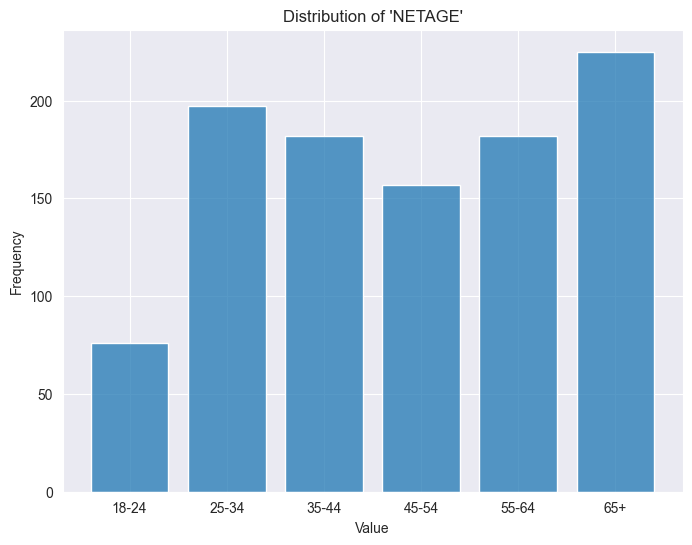

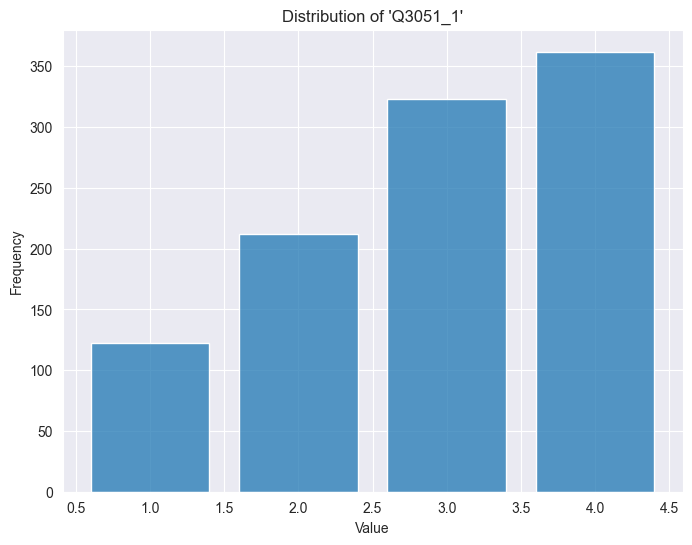

In [16]:
plot_histograms(df, ['NETAGE', 'Q3051_1'])


In [17]:
recoding_dict = {
    '1': '4',
    '2': '3',
    '3': '2',
    '4': '1'
}

columns_to_recode = [col for col in df.columns if col.startswith('Q3051')]

df = recode_columns(df, columns_to_recode, recoding_dict)


Recoding these columns: 
['Q3051_1', 'Q3051_2', 'Q3051_3', 'Q3051_4', 'Q3051_5', 'Q3051_6', 'Q3051_7', 'Q3051_8', 'Q3051_9', 'Q3051_10', 'Q3051_11', 'Q3051_12']

Value counts for 'Q3051_1' after recoding:
Q3051_1
1    362
2    323
3    212
4    122
Name: count, dtype: int64

Value counts for 'Q3051_2' after recoding:
Q3051_2
2    352
1    334
3    215
4    118
Name: count, dtype: int64

Value counts for 'Q3051_3' after recoding:
Q3051_3
1    399
2    279
3    226
4    115
Name: count, dtype: int64

Value counts for 'Q3051_4' after recoding:
Q3051_4
1    503
2    252
3    175
4     89
Name: count, dtype: int64

Value counts for 'Q3051_5' after recoding:
Q3051_5
1    425
2    332
3    170
4     92
Name: count, dtype: int64

Value counts for 'Q3051_6' after recoding:
Q3051_6
1    348
2    309
3    207
4    155
Name: count, dtype: int64

Value counts for 'Q3051_7' after recoding:
Q3051_7
2    378
1    292
3    249
4    100
Name: count, dtype: int64

Value counts for 'Q3051_8' after recodin

Generating histograms...


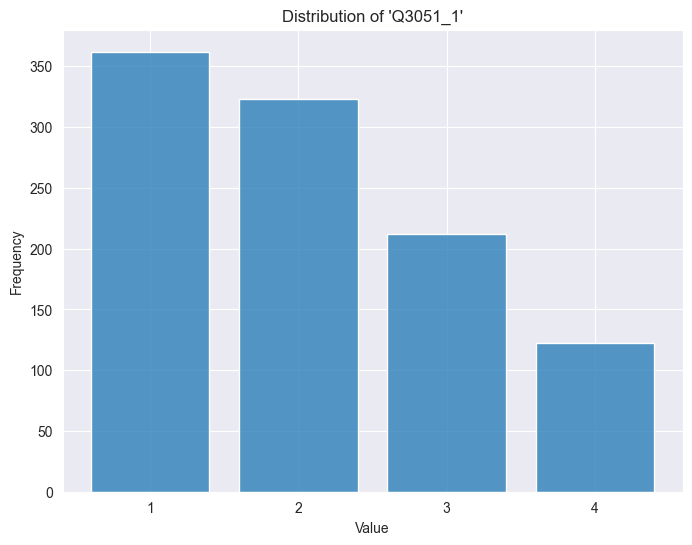

In [18]:
# Plot the histogram of the recoded variable to see if recoding worked
plot_histograms(df, ['Q3051_1'])

Now we've seen that the recode was successful. Let's see how a couple of different variables relate to each other.

We'll show some two-way plots that show the combined frequency of two variables.

In [19]:
def plot_two_way_distribution(df, col1, col2):
    """
    Generates and displays a two-way frequency plot for two specified columns.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        col1 (str): The name of the first column for the plot.
        col2 (str): The name of the second column for the plot.
    """
    print(f"\nGenerating two-way distribution for '{col1}' and '{col2}'...")

    # Generate the cross-tabulation table to see the raw counts
    cross_tab = pd.crosstab(df[col1], df[col2])
    print("\nTwo-Way Frequency Table:")
    print(cross_tab)

    # Plot the data using a clustered bar chart
    plt.figure(figsize=(10, 7))
    sns.countplot(x=col1, hue=col2, data=df, palette="viridis")
    plt.title(f"Two-Way Distribution of '{col1}' and '{col2}'")
    plt.xlabel(col1)
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.legend(title=col2)
    plt.tight_layout()
    plt.show()


Generating two-way distribution for 'NETAGE' and 'Q625R1'...

Two-Way Frequency Table:
Q625R1   1   2   3   4
NETAGE                
18-24    2  12  22  40
25-34   13  28  63  93
35-44   13  33  56  80
45-54   13  25  52  67
55-64   32  42  60  48
65+     54  81  54  36


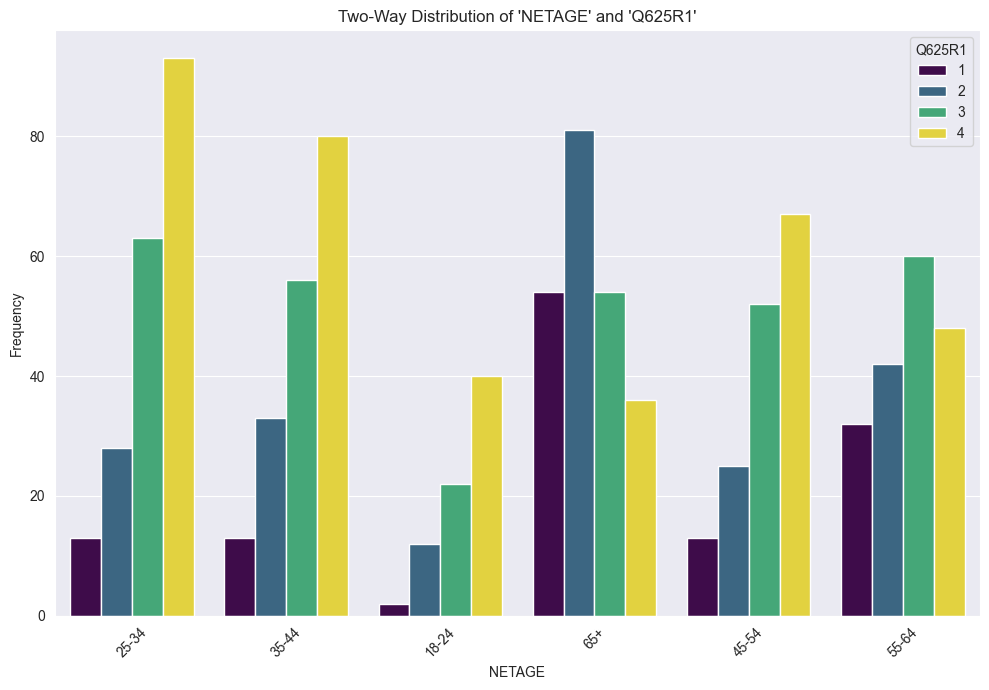

In [20]:
plot_two_way_distribution(df, 'NETAGE', 'Q625R1')


Another approach the textbook recommends is to draw a scatterplot matrix. Our data won't be that interesting in scatterplots because we have categorical rather than continuous variables. So we use a bubble chart instead.

In [21]:
def plot_bubble_chart_by_frequency(df, x_col, y_col):
    """
    Generates a bubble chart where the size of the dots represents the
    frequency of each unique combination of (x, y) values.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        x_col (str): The name of the column for the x-axis.
        y_col (str): The name of the column for the y-axis.
    """
    # 1. Count the occurrences of each unique combination
    frequency_counts = df.groupby([x_col, y_col]).size().reset_index(name='frequency')

    # 2. Plot the data using the 'size' aesthetic for frequency
    plt.figure(figsize=(10, 6))

    # Use the seaborn scatterplot to easily map frequency to dot size
    sns.scatterplot(
        data=frequency_counts,
        x=x_col,
        y=y_col,
        size='frequency',  # This is the key part that sizes the dots by frequency
        sizes=(20, 400),  # Adjusts the range of dot sizes
        alpha=0.8,
        legend='brief'
    )

    plt.title(f"Bubble Chart of {x_col} vs. {y_col} (Sized by Frequency)")
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.grid(True)
    plt.show()

In [22]:
def plot_bubble_grid(df, variables):
    """
    Generates a grid of bubble charts for all unique pairs of variables.
    The size of each dot represents the frequency of that (x, y) combination.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        variables (list): A list of column names to include in the grid.
    """
    # Create a new DataFrame with only the selected variables
    df_subset = df[variables]

    # Generate all unique pairs of variables
    import itertools
    pairs = list(itertools.combinations(variables, 2))

    num_plots = len(pairs)
    num_cols = min(3, num_plots)
    num_rows = (num_plots + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))
    axes = axes.flatten() if num_plots > 1 else [axes]

    for i, (x_col, y_col) in enumerate(pairs):
        # Count the occurrences of each unique combination
        frequency_counts = df_subset.groupby([x_col, y_col]).size().reset_index(name='frequency')

        # Use a single scatterplot for each subplot
        sns.scatterplot(
            data=frequency_counts,
            x=x_col,
            y=y_col,
            size='frequency',
            sizes=(20, 400),
            alpha=0.8,
            legend=False,
            ax=axes[i]
        )
        axes[i].set_title(f"{x_col} vs. {y_col}")
        axes[i].set_xlabel(x_col)
        axes[i].set_ylabel(y_col)
        axes[i].grid(True)

    # Hide unused subplots
    for j in range(num_plots, len(axes)):
        axes[j].set_visible(False)

    plt.suptitle("Grid of Bubble Charts (Sized by Frequency)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

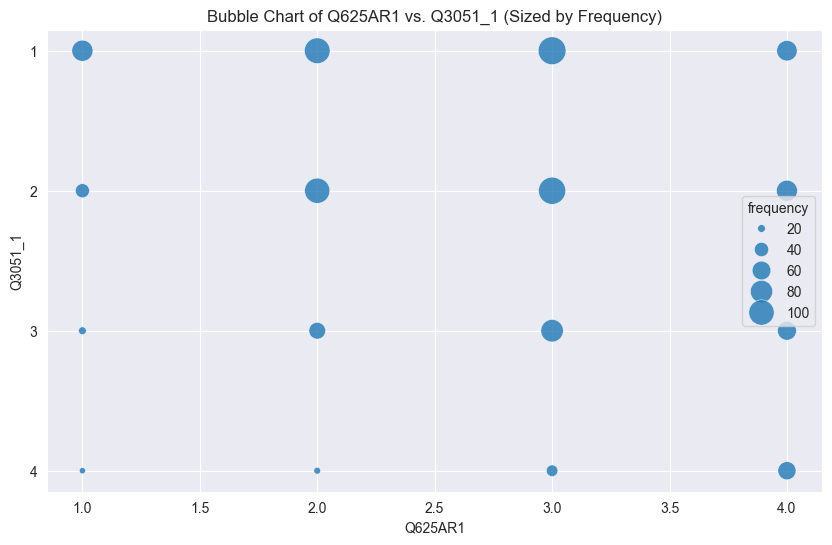

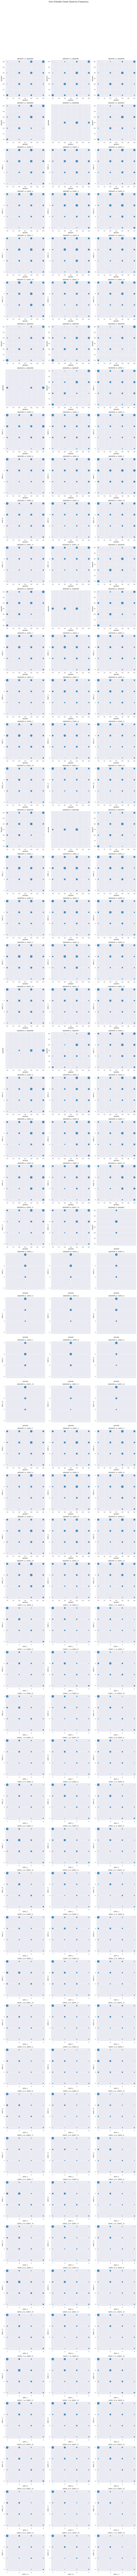

In [23]:
# Select the columns you want to include in the scatterplot matrix
stressors = [col for col in df.columns if col.startswith('Q625AR')]
neighborhood = [col for col in df.columns if col.startswith('Q3051')]
columns_to_plot = stressors + neighborhood

# Plot a bubble chart where dot size represents frequency
plot_bubble_chart_by_frequency(df, 'Q625AR1', 'Q3051_1')

# Plot a grid of bubble charts for multiple variables
plot_bubble_grid(df, columns_to_plot)

# Inferential Statistics

In [24]:
def independent_t_test(df, numerical_var, grouping_var):
    """
    Performs an independent samples t-test to compare the means of a
    numerical variable between two groups.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        numerical_var (str): The name of the numerical variable to test.
        grouping_var (str): The name of the grouping variable with two categories.
    """
    print(f"--- Independent T-Test: {numerical_var} by {grouping_var} ---")

    # Filter data for the two groups
    group_1 = df[df[grouping_var] == df[grouping_var].unique()[0]][numerical_var].dropna()
    group_2 = df[df[grouping_var] == df[grouping_var].unique()[1]][numerical_var].dropna()

    # Calculate and print group means
    print(f"Mean for {df[grouping_var].unique()[0]}: {group_1.mean():.4f}")
    print(f"Mean for {df[grouping_var].unique()[1]}: {group_2.mean():.4f}")

    # Perform the t-test
    t_stat, p_value = stats.ttest_ind(group_1, group_2, equal_var=False)  # Assumes unequal variances

    # Print results and interpretation
    print(f"T-Statistic: {t_stat:.4f}")
    print(f"P-value: {p_value:.4f}")

    alpha = 0.05
    if p_value < alpha:
        print("\nResult: The difference in means is statistically significant.")
        print("This suggests that the two groups are different on this variable.")
    else:
        print("\nResult: The difference in means is not statistically significant.")
        print("This suggests that the two groups are not different on this variable.")

In [25]:
def chi_squared_test(df, var1, var2):
    """
    Performs a chi-squared test of independence for two categorical variables.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        var1 (str): The name of the first categorical variable.
        var2 (str): The name of the second categorical variable.
    """
    print(f"\n--- Chi-Squared Test: {var1} vs. {var2} ---")

    # Create a contingency table
    contingency_table = pd.crosstab(df[var1], df[var2])
    print("Contingency Table:")
    print(contingency_table)

    # Perform the chi-squared test
    chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

    # Print results and interpretation
    print(f"\nChi-Squared Statistic: {chi2_stat:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"Degrees of Freedom: {dof}")

    alpha = 0.05
    if p_value < alpha:
        print("\nResult: The variables are statistically associated.")
        print("This suggests there is a relationship between the two variables.")
    else:
        print("\nResult: The variables are not statistically associated.")
        print("This suggests there is no relationship between the two variables.")

## T-Test Example

T-tests compare the means of groups. Our data is mostly categorical, so means aren't that interesting. Let's make a variable that counts the number of stressors someone said were somewhat or very significant so we can do some comparisons. We'll also make a binary age variable so we have just two groups to compare.

In [26]:
variables_to_count = [col for col in df.columns if col.startswith('Q625')]
print(f"Found {len(variables_to_count)} variables to count: {variables_to_count}")

# Define the values to include in the count
values_to_count = [3, 4]

# Convert variables to numeric and then count how many times each value appears
# This method handles missing values and non-numeric data gracefully
df['stressors_count'] = df[variables_to_count].apply(pd.to_numeric, errors='coerce').isin(values_to_count).sum(axis=1)


Found 33 variables to count: ['Q625R1', 'Q625R2', 'Q625R3', 'Q625R4', 'Q625R5', 'Q625R6', 'Q625R7', 'Q625R8', 'Q625R9', 'Q625R10', 'Q625R11', 'Q625R12', 'Q625AR1', 'Q625AR2', 'Q625AR3', 'Q625AR4', 'Q625AR5', 'Q625AR6', 'Q625AR7', 'Q6255R1', 'Q6255R2', 'Q6255R3', 'Q6255R4', 'Q6255R5', 'Q6255R6', 'Q6255R7', 'Q6255R8', 'Q6255R9', 'Q6255R10', 'Q6255R11', 'Q6255R12', 'Q6255R13', 'Q6255R14']


In [27]:
# create a binary age variable
df['NETAGE_binary'] = df['NETAGE'].replace({'18-24': 'Young', '25-34': 'Young',
                                            '35-44': 'Old', '45-54': 'Old',
                                            '55-64': 'Old', '65+': 'Old'})

In [28]:
# Let's compare the mean of Q810R1 between the 'Young' and 'Old' age groups
independent_t_test(df, 'stressors_count', 'NETAGE_binary')

--- Independent T-Test: stressors_count by NETAGE_binary ---
Mean for Young: 10.1648
Mean for Old: 8.0737
T-Statistic: 6.1397
P-value: 0.0000

Result: The difference in means is statistically significant.
This suggests that the two groups are different on this variable.


# Chi-Squared Test Example

We'll see if there's a relationship between the answers to these two questions:
- Q625AR4: Please indicate how significant a source of stress it is in your life: violence toward police
- Q3051_1: How would you rate your neighborhood on the following?: Lack of respect for rules and laws




In [29]:
# First, we need to clean and ensure they are categorical
# Please indicate how significant a source of stress it is in your life: violence toward police
df['Q625AR4'] = pd.to_numeric(df['Q625AR4'], errors='coerce').astype('category')  #
# How would you rate your neighborhood on the following?: Lack of respect for rules and laws
df['Q3051_1'] = pd.to_numeric(df['Q3051_1'], errors='coerce').astype('category')

chi_squared_test(df.dropna(subset=['Q625AR4', 'Q3051_1']), 'Q625AR4', 'Q3051_1')


--- Chi-Squared Test: Q625AR4 vs. Q3051_1 ---
Contingency Table:
Q3051_1    1    2   3   4
Q625AR4                  
1        117   58  33  23
2         86  114  58  21
3        100  100  88  30
4         59   51  33  48

Chi-Squared Statistic: 79.1118
P-value: 0.0000
Degrees of Freedom: 9

Result: The variables are statistically associated.
This suggests there is a relationship between the two variables.


# Linear Models

We need continuous variables again for interesting analyses here. We have one for the number of stressors someone indicated. We can create another one for the big problems in their neighborhood.

In [30]:
variables_to_count = [col for col in df.columns if col.startswith('Q3051')]
print(f"Found {len(variables_to_count)} variables to count: {variables_to_count}")

# Define the values to include in the count
values_to_count = [4] # only big problems

# Convert variables to numeric and then count how many times each value appears
# This method handles missing values and non-numeric data gracefully
df['problems_count'] = df[variables_to_count].apply(pd.to_numeric, errors='coerce').isin(values_to_count).sum(axis=1)


Found 12 variables to count: ['Q3051_1', 'Q3051_2', 'Q3051_3', 'Q3051_4', 'Q3051_5', 'Q3051_6', 'Q3051_7', 'Q3051_8', 'Q3051_9', 'Q3051_10', 'Q3051_11', 'Q3051_12']


In [31]:
def perform_linear_regression(df, predictor, outcome):
    """
    Performs a simple linear regression and prints the results table.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        predictor (str): The name of the independent variable.
        outcome (str): The name of the dependent (outcome) variable.
    """
    print(f"\n--- Simple Linear Regression: {outcome} vs. {predictor} ---")

    # Drop rows with missing data for the two variables
    temp_df = df[[predictor, outcome]].dropna()

    # Define the independent (X) and dependent (y) variables
    X = temp_df[predictor]
    y = temp_df[outcome]

    # Add a constant (intercept) to the predictor variable
    X = sm.add_constant(X)

    # Create and fit the OLS model
    model = sm.OLS(y, X)
    results = model.fit()

    # Print the regression table
    print(results.summary())

    # Extract p-value and coefficient for interpretation
    p_value = results.pvalues[predictor]
    coefficient = results.params[predictor]

    alpha = 0.05
    if p_value < alpha:
        print(f"\nResult: There is a statistically significant relationship between {predictor} and {outcome}.")
        print(f"Interpretation: For every one-point increase in {predictor}, the model predicts a {coefficient:.4f}-point change in {outcome}.")
    else:
        print(f"\nResult: There is no statistically significant relationship between {predictor} and {outcome}.")


    return results

def plot_scatterplot(df, x_var, y_var):
    """
    Plots a scatterplot of two variables with a regression line.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        x_var (str): The name of the variable for the x-axis.
        y_var (str): The name of the variable for the y-axis.
    """
    print(f"\n--- Scatterplot: {y_var} vs. {x_var} ---")

    # Drop rows with missing data for the two variables
    temp_df = df[[x_var, y_var]].dropna()

    plt.figure(figsize=(10, 6))

    # Plot the scatter points
    plt.scatter(temp_df[x_var], temp_df[y_var], alpha=0.5, label='Data Points')

    # Perform linear regression to get the line
    slope, intercept, _, _, _ = stats.linregress(temp_df[x_var], temp_df[y_var])

    # Create the regression line's data
    x_line = np.array([temp_df[x_var].min(), temp_df[x_var].max()])
    y_line = slope * x_line + intercept

    # Plot the regression line
    plt.plot(x_line, y_line, color='red', label=f'Regression Line\n(y = {slope:.2f}x + {intercept:.2f})')

    plt.title(f'Scatterplot of {y_var} vs. {x_var}')
    plt.xlabel(x_var)
    plt.ylabel(y_var)
    plt.grid(True)
    plt.legend()
    plt.show()


--- Scatterplot: stressors_count vs. problems_count ---


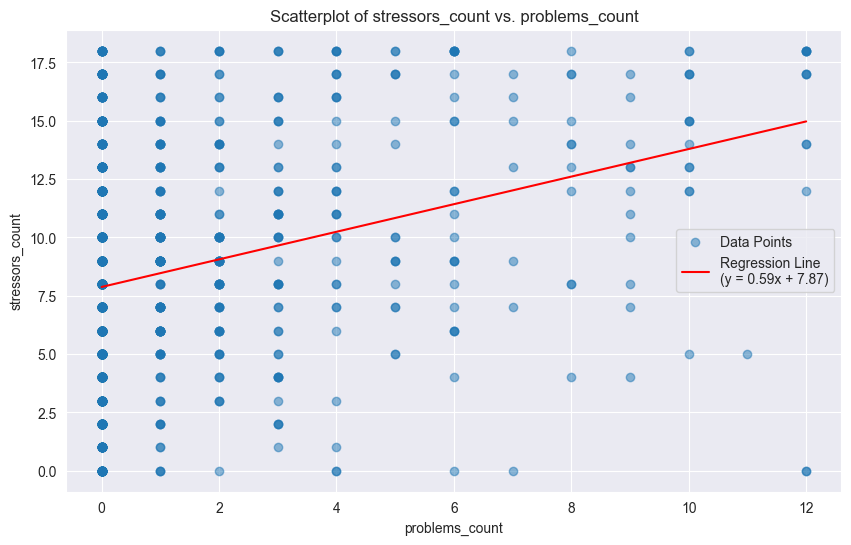

In [32]:
# plot first
plot_scatterplot(df, 'problems_count', 'stressors_count')


In [33]:
# then run regression
model = perform_linear_regression(df, 'problems_count', 'stressors_count')


--- Simple Linear Regression: stressors_count vs. problems_count ---
                            OLS Regression Results                            
Dep. Variable:        stressors_count   R-squared:                       0.092
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     103.5
Date:                Mon, 01 Sep 2025   Prob (F-statistic):           3.15e-23
Time:                        13:34:05   Log-Likelihood:                -3002.6
No. Observations:                1019   AIC:                             6009.
Df Residuals:                    1017   BIC:                             6019.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------